# Глубинное обучение для текстовых данных, ФКН ВШЭ
## Домашнее задание 5: Retrieval‑Augmented Generation (RAG)
### Оценивание и штрафы

Максимально допустимая оценка за работу — __10 баллов__.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Весь код должен быть написан самостоятельно. Чужим кодом для пользоваться запрещается даже с указанием ссылки на источник. В разумных рамках, конечно. Взять пару очевидных строчек кода для реализации какого-то небольшого функционала можно.

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

__Мягкий дедлайн 16.12.24 23:59__ \
__Жесткий дедлайн 19.12.24 23:59__

### О задании

В этом домашнем задании вам предлагается реализовать ассистента для кулинарных советов с помощью RAG, который помимо всего прочего может ходить в итернет за дополнительной информацией. Всю логику системы нужно будет написать самостоятельно без специализорованных библиотек. Мы разделили ее на несколько логических компонент, каждой из которых будет отведено отдельное задание:
1. Векторная база данных с быстрым семантическим поиском
2. Разбиение текстов на куски.
3. Ранжирование документов по релевантности
4. Формирование контекста для модели и генерация ответа

### О данных

В качестве базы данных мы будем использовать пользовательские рецепты с сайта "Поваренок.Ру". Они получены с помощью веб-парсинга сайта, поэтому местами тексты недостаточно чистые. Всего в датасете содержится 84130 рецептов.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import uuid
from tqdm.auto import tqdm
from datasets import load_dataset

from collections import defaultdict
from typing import List, Tuple
from sklearn.metrics.pairwise import cosine_similarity



/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Загрузка датасета и модели

Таблица с рецептами хранится в файле `povarenok.csv`. Каждая запись содержит название рецепта, список ингредиентов и сам рецепт. Несмотря на то, что всего датасете хранится 84130 записей, в рамках этого задания мы будем работать с первыми 10-ю тысячами для того, чтобы все работало быстрее. При желании вы можете взять больше.

In [5]:
# dataset = load_dataset('csv', data_files=['povarenok.csv'], split='train')


In [13]:
# dataset = dataset.select(range(40000))

In [15]:
# dataset.to_csv('povarenok_small.csv')

Creating CSV from Arrow format:   0%|          | 0/40 [00:00<?, ?ba/s]

79334716

In [2]:
dataset = load_dataset('csv', data_files=['povarenok.csv'], split='train')
dataset = dataset.select(range(10000))
dataset

Dataset({
    features: ['name', 'ingredients', 'text'],
    num_rows: 10000
})

In [33]:
dataset[0]

{'name': 'Густой молочно-клубничный коктейль',
 'ingredients': "['Молоко', 'Клубника', 'Сахар']",
 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}

Посмотрим на распределение длин текстов. Нам важно знать с чем мы имеем дело, ведь RAG подразумевает, что мы будем подавать тексты на вход модели.

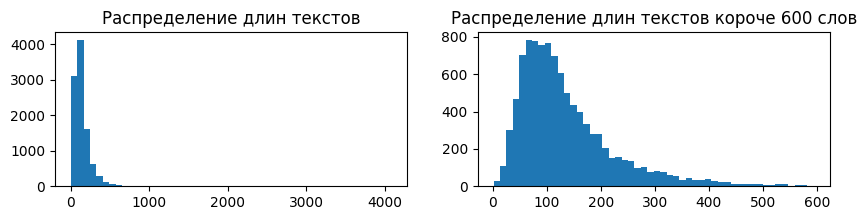

In [8]:
lens = np.array([len(dataset[i]['text'].split()) for i in range(len(dataset))])

plt.figure(figsize=(10, 2))
plt.subplot(1, 2, 1)
plt.hist(lens, bins=50)
plt.title('Распределение длин текстов')

plt.subplot(1, 2, 2)
plt.hist(lens[lens < 600], bins=50)
plt.title('Распределение длин текстов короче 600 слов')

plt.show()

Видим, что тексты часто довольно длинные. Поэтому смухлевать не получится и перед векторизацией нужно будет разбивать каждый текст на небольшие куски, чтобы не перегружать контекст модели и чтобы потерять важную информацию при векторизацци текстов на этапе складывания их в векторную базу данных.

Приступим к реализации RAG.

## Retrieval‑Augmented Generation

В качестве основы для ассистента возьмите модель [`Qwen/Qwen2-1.5B-Instruct`](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) из huggingface. Важно, что это `Instruct` модель, то есть она предлазначена для общения в формате диалога.

__Задание 0 (0 баллов).__ Проверьте, как модель отвечает на кулинарные вопросы без RAG. Это необходимо сделать, чтобы понять, нужен ли вообще RAG для данной задачи.

In [8]:
from transformers import pipeline
import torch

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

generation_pipeline = pipeline(
    "text-generation",
    model="RefalMachine/ruadapt_qwen2.5_3B_ext_u48_instruct_v4",
    # model="RefalMachine/RuadaptQwen2.5-1.5B-instruct",
    device=device,
    torch_dtype=torch.float16)

cuda


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
Device set to use cuda


In [12]:
query = 'Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль'

In [13]:
messages = [
    {"role": "system", "content": "Ты полезный и дружелюбный помощник, шеф-повар."},
    {"role": "user", "content": query},
]
output = generation_pipeline(messages, max_new_tokens=256, do_sample=True, temperature=0.2, top_p=0.7)

answer = output[0]['generated_text'][-1]['content']

print(answer)

Для приготовления густого и вкусного молока с клубникой можно использовать следующие ингредиенты:

1. **Молоко** - 500 мл свежего цельнозернового или сгущенного молока.
2. **Клубника** - 300 г свежих или замороженных ягод.
3. **Сахар** - 1 столовая ложка для сладости (по вкусу).
4. **Лимонный сок** - 1 чайная ложка для освежающего вкуса.
5. **Ванильный сахар** - 1/2 чайной ложки для аромата.
6. **Миндальное молоко** - 100 мл для дополнительного вкуса и текстуры.

### Инструкция по приготовлению:

1. **Подготовка ягод**: Очистите ягоды от кожицы и семечек. Если используете замороженные ягоды, их предварительно разморозьте.

2. **Приготовление**: В большой миске смешайте подготовленные ягоды, сахар, лимонный сок и ванильный сахар. Перемешайте до полного растворения сахара.

3. **Добавление молока**: Добавьте молоко в миску с ягодами и аккуратно перемешайте, чтобы ягоды равномерно распределились по жидкости.

4. **Заг


### Locality Sensitive Hashing (LSH)

В RAG для каждого запроса необходимо искать релевантные документы по векторной базе данных. Так как документов очень много, подсчет релевантности для каждого из них будет занимать очень много времени. Поэтому нам важно, чтобы поиск был быстрым. Для достижения этого мы даже готовы немного пожертвовать точностью.

В этой секции вам предстоит реализовать [Locality Sensitive Hashing](https://ru.wikipedia.org/wiki/Locality-sensitive_hashing).

Идея LSH довольна проста. Разделим все векторы из базы данных на группы, состоящие из похожих векторов. В начале поиска определим группу, которая соответствует вектору запроса и будем считать релевантность только для объектов из этой группы. Для разбиения на группы мы введем несколько хеш-функций. Каждая их них будет строиться по следующему алгоритму:
1. Сгенерируем $k$ случайных векторов (векторы нормали гиперплоскости)
2. Для отдельной точки (вектора) в базе данных и вектора нормали запишем 1, если точка лежит над соответствующей гиперплоскостью. В обратном случае запишем 0.
3. Повторим процедуру для всех точек и векторов нормали. Так мы для каждой точки получим список из $k$ 0 и 1, который и будет хешем.
4. Запишем в хеш-таблицу найденные точки для каждого хеша.
5. Повторим шаги 1-4 $L$ раз и получим $L$ разных хеш-таблиц.

Теперь для каждого нового вектора $q$ мы можем очень быстро найти набор векторов похожих на него. Для этого посчитаем хеши запроса в каждой хеш-таблице и возьмем все точки, у которых хеш совпал c $q$ хотя бы в одной из них. Затем переранжируем найденные точки по релевантности (расстоянию до вектора запроса) и оставим заданное число самых близких.

Сложность формирования хеш-таблиц можно оценить как $O(nLkd)$, где $n$ – число векторов в базе данных, а $d$ – размерность вектора. В то же время сложность поиска LSH – $O(Lkd + (nLp) \cdot d)$, где $p$ – вероятность того, что хеш двух случайных точек совпадет ($p$ стремится к 0). Сложность полного перебора – $O(nd)$, поэтому при поиске LSH работает быстрее почти в $\frac{n}{Lk}$ раз!

__Задание 1 (3 балла).__ Реализуйте векторную базу данных LSH поиском. База данных должна уметь добавлять новые векторы, а так же по входному вектору быстро находить ближайшие к нему. Во время создании базы данных сгенерируйте необходимое число хеш-функций. Подумайте о том, как выбрать количество хеш-таблиц и число случайных векторов, а так же о том, из какого распределения брать эти случайные векторы. При добавлении нового вектора в базу данных, считайте для него хеш и записывайте, каким группам от принадлежит.

Постарайтесь оптимизировать код и не забудьте протестировать, что ваш LSH работает так, как надо. Проще всего это сделать, построив базу данных с точками на двумерной плоскости. Также сравните скорость LSH поиска с полным перебором. Если вы все сделали правильно, то для 1000 точек вы должны получить ускорение поиска примерно в 4 раза.

In [7]:
# your code here

In [4]:
class LSHIndex:
    def __init__(self, k: int, L: int, dim: int):
        """
        Args:
            k (int): Number of hyperplanes per hash function.
            L (int): Number of hash tables.
            dim (int): Dimensionality of vectors.
        """
        self.k = k
        self.L = L
        self.dim = dim
        self.hash_tables = [defaultdict(list) for _ in range(L)]
        self.hyperplanes = [np.random.randn(k, dim) for _ in range(L)]
        self.vectors = []  # Store original vectors
        self.vector_ids = []  # Optional: store document IDs or metadata

    def _hash(self, vector: np.ndarray, hyperplanes: np.ndarray) -> str:
        """Compute hash for one table: sign of dot product with each hyperplane."""
        bools = (np.dot(hyperplanes, vector) > 0).astype(int)
        return ''.join(map(str, bools))  # e.g., "10101"

    def add_vector(self, vector: np.ndarray, metadata=None):
        """Add a vector to the index (into all hash tables)."""
        vector = vector / np.linalg.norm(vector)  # Normalize
        idx = len(self.vectors)
        self.vectors.append(vector)
        self.vector_ids.append(metadata)

        for i in range(self.L):
            h = self._hash(vector, self.hyperplanes[i])
            self.hash_tables[i][h].append(idx)

    def query(self, q: np.ndarray, top_k=5) -> List[Tuple[int, float]]:
        """Query for approximate nearest neighbors."""
        q = q / np.linalg.norm(q)
        candidate_idxs = set()

        # Gather candidates from all tables
        for i in range(self.L):
            h = self._hash(q, self.hyperplanes[i])
            candidate_idxs.update(self.hash_tables[i].get(h, []))

        # Re-rank candidates using cosine similarity
        candidates = [(idx, cosine_similarity([q], [self.vectors[idx]])[0][0]) for idx in candidate_idxs]
        candidates.sort(key=lambda x: -x[1])
        return candidates[:top_k]


In [64]:
# Create dummy vector data
np.random.seed(42)
dimension = 128
num_vectors = 1000
vectors = [np.random.randn(dimension) for _ in range(num_vectors)]

# Create index
lsh = LSHIndex(k=10, L=5, dim=dimension)

# Add vectors to index
for i, vec in enumerate(vectors):
    lsh.add_vector(vec, metadata=f"doc_{i}")

# Query with a random vector
query_vector = np.random.randn(dimension)
results = lsh.query(query_vector, top_k=5)

# Print top 5 similar vectors
for idx, score in results:
    print(f"Vector ID: {lsh.vector_ids[idx]}, Cosine Similarity: {score:.4f}")


Vector ID: doc_479, Cosine Similarity: 0.1209
Vector ID: doc_178, Cosine Similarity: 0.0949
Vector ID: doc_444, Cosine Similarity: 0.0564


In [69]:
from copy import deepcopy

In [9]:
from sentence_transformers import SentenceTransformer

In [81]:
from sentence_transformers import SentenceTransformer

texts = deepcopy(dataset[:100]['text'])  # First 50 texts

# Encode texts into vectors
encoder = SentenceTransformer('all-MiniLM-L6-v2')  # Small & fast
vectors = encoder.encode(texts, normalize_embeddings=True)  # Shape: (50, 384)


In [82]:
# Create index
lsh = LSHIndex(k=10, L=5, dim=384)

# Add vectors to index
for i, vec in enumerate(vectors):
    lsh.add_vector(vec, metadata=f"doc_{i}")

# Query with a vector
query_vector = vectors[0]
results = lsh.query(query_vector, top_k=5)

# Print top 5 similar vectors
for idx, score in results:
    print(f"Vector ID: {lsh.vector_ids[idx]}, Cosine Similarity: {score:.4f}")

Vector ID: doc_0, Cosine Similarity: 1.0000
Vector ID: doc_82, Cosine Similarity: 0.8718
Vector ID: doc_44, Cosine Similarity: 0.8561
Vector ID: doc_52, Cosine Similarity: 0.8404
Vector ID: doc_56, Cosine Similarity: 0.8378


In [86]:
dataset[0]

{'name': 'Густой молочно-клубничный коктейль',
 'ingredients': "['Молоко', 'Клубника', 'Сахар']",
 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}

In [87]:
dataset[82]

{'name': 'Мусс из ягод',
 'ingredients': "['Ягода', 'Сахар', 'Желатин']",
 'text': 'СВЕЖИЕ ИЛИ ЗАМОРОЖЕННЫЕ ЯГОДЫ ПЕРЕБРАТЬ И ПРОМЫТЬ В ХОЛОДНОЙ ВОДЕ. РАЗМЯТЬ ЛОЖКОЙ И ПРОТЕРЕТЬ СКВОЗЬ СИТО. ВЫЖИМКИ ОТ ЯГОД ЗАЛИТЬ 2 СТАКАНАМИ ВОДЫ ГОРЯЧЕЙ, ВСКИПЯТИТЬ И ПРОЦЕДИТЬ. В ПОЛУЧЕННЫЙ СОК ПОЛОЖИТЬ САХАР И ПРЕДВАРИТЕЛЬНО РАЗВЕДЕННЫЙ ЖЕЛАТИН. ПОМЕШИВАЯ ДОВЕСТИ СИРОП ДО КИПЕНИЯ. В ОХЛАЖДЕННЫЙ СИРОП ВЫЛОЖИТЬ ЯГОДНОЕ ПЮРЕ И ВЗБИТЬ ДО ОБРАЗОВАНИЯ ОДНОРОДНОЙ МАССЫ. КАК ТОЛЬКО МАССА ЗАГУСТЕЕТ ВЫЛОЖИТЬ ЕЕ В ФОРМЫ И ОХЛАДИТЬ. НА 1 СТАКАН ЯГОД 3 /4 СТАКАНА САХАРА. 15 Г ЖЕЛАТИНА.'}

In [88]:
dataset[44]

{'name': 'Ватрушка с яблоками и клюквой "Наоборот"',
 'ingredients': "['Яйцо куриное', 'Сметана', 'Сахар', 'Соль', 'Масло сливочное', 'Мука пшеничная', 'Сода', 'Творог', 'Крупа манная', 'Яблоко', 'Клюква', 'Ванильный сахар']",
 'text': 'Начнем приготовление ватрушки с начинки. Для этого яблоки помыть и очистить от кожуры и сердцевины. Разрезать на 8 долек. Обвалять в ванильном сахаре. Разложить яблоки и клюкву в форме для выпечки (у меня силиконовая). Далее приготовить творожную начинку. Для этого смешать в миске творог, сахар, яйца, манку. Взбить погружным блендером до получения однородной массы. Распределить творожную массу поверх яблок. Для теста в миске соединить яйцо, сметану, сахар, соль, перемешать. Добавить растопленное сливочное масло, перемешать. Далее просеять муку с содой и снова хорошо перемешать. Распределить тесто поверх творожного слоя. Поставить в холодную духовку, включить на 180 градусов, готовить 40-45 мин. Сразу из духовки не вынимать, а оставить ватрушку там до по

### Разбиение текста на куски

Так как некоторые тексты довольно длинные, если мы будем кодировать их целиком одним вектором, то часть информации потеряется. Вектор все таки имеет ограниченный размер. Чтобы не терять информацию, мы поделим текст на куски и будем кодировать каждый кусок отдельно.

__Задание 2 (2 балла).__ Реализуйте [рекурсивное разбиение](https://dev.to/eteimz/understanding-langchains-recursivecharactertextsplitter-2846) текста с уровнями `["\n\n", "\n", " ", ""]`. Добавьте пересечение между кусками для уровней `[" ", ""]`. То есть если целый абзац помещается в один кусок, то пересекать его ни с чем не надо (в нем содержится законченная мысль), а если абзац не влезает и его приходится делить по словам (или символам), то нужно добавить пересечение со словами из соседних кусков того же абзаца.

Значения для максимального размера каждого куска и длины пересечения выберите самостоятельно. Надежнее всего брать размер пересечения равным половине длины куска.

In [ ]:
## ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 
# This behaviour is the source of the following dependency conflicts.
#googletrans 4.0.0rc1 requires httpx==0.13.3, but you have httpx 0.28.1 which is incompatible.

In [15]:
%pip install langchain

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     |████████████████████████████████| 1.0 MB 4.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 75.4 MB/s eta 0:00:01
     |████████████████████████████████| 442 kB 83.2 MB/s eta 0:00:01
     |████████████████████████████████| 367 kB 82.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.4 MB 55.7 MB/s eta 0:00:01
     |████████████████████████████████| 73 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 130 kB 82.5 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 8.6 MB/s  eta 0:00:01
     |████████████████████████████████| 580 kB 83.3 MB/s eta 0:00:01
  Attempting uninstall: h11
    Found existing installation: h11 0.9.0
    Uninstalling h11-0.9.0:
      Successfully uninstalled h11-0.9.0
  Attempting uninstall: httpcore
    Found existing installation: httpcore 0.9.1
    Uninstalling httpcore-0.9.1:
      Successfully uninstalled httpcore-0.9.1
  Attempting u

In [5]:
# your code here
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [6]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=256, chunk_overlap=128)

In [12]:
text = (
    """This is a long paragraph that will be split by word or character level if needed. Another sentence follows.
    Second paragraph with its own content. Still within the same paragraph."""
)

chunks = text_splitter.split_text(text)


In [13]:
chunks 

['This is a long paragraph that will be split by word or character level if needed. Another sentence follows.\n    Second paragraph with its own content. Still within the same paragraph.']

In [44]:
print(dataset[9000])

{'name': 'Роза из картофеля', 'ingredients': "['Картофель']", 'text': '1. Берем картофель 2. Очищаем и делаем заготовку, придав с одной стороны более округлую форму 3. На округлой части заготовки вырезаем первый листок 4. Вырезаем мякоть из-под первого лепестка, поставив нож под острым углом наклона к внутренней стороне лепестка. Э тим мы создаем площадку для вырезания второго ряда лепестков. ... 5. Второй лепесток начинаем резать из-под первого. Каждый последующий лепесток должен заходить под предыдущий. 6. Вынуть мкоть из-под второго лепестка и т. д. 7. Аналогично сделать и следующие ряды, постепенно уменьшая размер лепестков и изменяя их наклон, собирая розу в бутон 8. Вот розочка и готова'}


In [45]:
text_splitter.split_text(dataset[9000]['text'])

['1. Берем картофель 2. Очищаем и делаем заготовку, придав с одной стороны более округлую форму 3. На округлой части заготовки вырезаем первый листок 4. Вырезаем мякоть из-под первого лепестка, поставив нож под острым углом наклона к внутренней стороне',
 'вырезаем первый листок 4. Вырезаем мякоть из-под первого лепестка, поставив нож под острым углом наклона к внутренней стороне лепестка. Э тим мы создаем площадку для вырезания второго ряда лепестков. ... 5. Второй лепесток начинаем резать из-под первого.',
 'Э тим мы создаем площадку для вырезания второго ряда лепестков. ... 5. Второй лепесток начинаем резать из-под первого. Каждый последующий лепесток должен заходить под предыдущий. 6. Вынуть мкоть из-под второго лепестка и т. д. 7. Аналогично сделать и',
 'последующий лепесток должен заходить под предыдущий. 6. Вынуть мкоть из-под второго лепестка и т. д. 7. Аналогично сделать и следующие ряды, постепенно уменьшая размер лепестков и изменяя их наклон, собирая розу в бутон 8. Вот ро

In [59]:
def recursive_split(text, max_len, levels=["\n\n", "\n", " "], intersection=20):
    """
    Recursively splits the text using levels of separators.
    Adds overlapping (intersection) between chunks at " " and "" levels.
    
    Args:
        text (str): The input text to split.
        max_len (int): The maximum allowed length for each chunk.
        levels (list): List of separators, from coarse to fine.
        intersection (int): Number of overlapping words/chars for " " or "" levels.
        
    Returns:
        List[str]: List of text chunks.
    """
    def split_level(text, level_index):
        if level_index >= len(levels):
            return [text]
        
        sep = levels[level_index]
        parts = text.split(sep)
        
        result = []
        buffer = []

        for part in parts:
            candidate = sep.join(buffer + [part]) if buffer else part

            if len(candidate) <= max_len:
                buffer.append(part)
                continue

            if buffer:
                chunk = sep.join(buffer)
                if len(chunk) > 0:
                    result.extend(split_level(chunk, level_index + 1))
                buffer = [part]
            else:
                result.extend(split_level(part, level_index + 1))

        # Handle remaining buffer
        if buffer:
            chunk = sep.join(buffer)
            result.extend(split_level(chunk, level_index + 1))

        # Apply overlap for fine-grained splits
        if sep in [" ", ""]:
            overlapped = []
            for i, chunk in enumerate(result):
                if sep == " ":
                    tokens = chunk.split(sep)
                else:
                    tokens = list(chunk)

                start = max(0, len(tokens) - intersection)
                if i < len(result) - 1:
                    next_chunk = result[i + 1]
                    if sep == " ":
                        next_tokens = next_chunk.split(sep)
                    else:
                        next_tokens = list(next_chunk)
                    overlap = tokens[start:] + next_tokens[:intersection]
                    merged = sep.join(overlap) if sep == " " else "".join(overlap)
                    result[i + 1] = sep.join(next_tokens) if sep == " " else "".join(next_tokens)
                overlapped.append(chunk)
            return overlapped
        else:
            return result

    return split_level(text, 0)


In [60]:
text_1 = (
    "This is a long paragraph that will be split by word or character level "
    "if needed. Another sentence follows.\n\n"
    "Second paragraph with its own content.\nStill within the same paragraph."
)
chunks = recursive_split(dataset[1000]['text'], max_len=256)
for i, chunk in enumerate(chunks):
    print(f"Chunk {i + 1}:\n{chunk}\n{'='*20}")


Chunk 1:
1. Лук почистить, нарезать мелким кубиком. Грибы мелко нарезать. 2. В сковороде разогреть масло, обжарить лук до прозрачности, добавить грибы и обжаривать до золотистого цвета. Затем добавить петрушку, соль, перец и снять с огня. 3. Куриное филе вымыть,
Chunk 2:
обсушить, сделать надрезы-кармашки. Выложить в кармашки грибную начинку. Аккуратно соединить кармашки, можно сколоть зубочисткой, чтоб начинка не выпала. 4. Сковороду разогреть, обжарить курицу с двух сторон до золотистой корочки, переложить в форму для
Chunk 3:
запекания. Для запеканки кабачок нарезать тонкими пластинками. В сковороде разогреть масло. Чеснок мелко нарезать, обжарить до прозрачности, влить сливки, потомить, пока сливки загустеют, добавить соль, перец, снять с огня. 5. В форму, я брала кольцо
Chunk 4:
диаметром 10 см, смазанную маслом, выкладывать слой кабачка, слой сливочного соуса. Затем снова кабачки и соус. Духовку разогреть до 180С. Поставить форму с курицей и форму с кабачками в духовку. Готовить 

## RAG

Наконец мы можем начать собирать систему RAG. Для начала соберем векторую базу данных из кусков рецептов. Для получения эмбеддингов текстов возьмите модель [`intfloat/multilingual-e5-large`](https://huggingface.co/intfloat/multilingual-e5-large), она создана специально для этой задачи и хорошо работает с русским языком.

__Задание 3 (1 балл).__ Соберите векторую базу данных с помощью написанных вами функций. Процесс не должен занимать много времени с GPU, но мы рекомендуем сохранить результат на диск, чтобы не векторизовать весь датасет заново при перезапуске ядра. Проверьте, что по запросу возвращаются релевантные тексты.

In [17]:
encoder = SentenceTransformer("intfloat/multilingual-e5-large")

In [98]:
for i,r  in enumerate(tqdm(dataset[:10])):
    print(dataset[i])

100%|██████████| 3/3 [00:00<00:00, 5001.16it/s]

{'name': 'Густой молочно-клубничный коктейль', 'ingredients': "['Молоко', 'Клубника', 'Сахар']", 'text': 'Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!'}
{'name': 'Рулетики', 'ingredients': "['Сыр твердый', 'Чеснок', 'Яйцо куриное', 'Грейпфрут', 'Лук зеленый', 'Листья салата', 'Майонез']", 'text': 'Разобрать салат на отдельные листочки, помыть и просушить. Натереть на крупной терке сыр, яйца, выдавить через чесночницу чеснок. Лук порезать. Несколько долек грейпфрута очистить от пленок, нарезать на мелкие кусочки. Яйца отварить, почистить и мелко нарубить. Смешать все с майонезом. Выложить на листья салата и завернуть каждый в рулетик.'}
{'name': 'Салат "Баклажанчик"', 'ingredients': "['Баклажан'

In [49]:
dataset[999]

{'name': 'Равиоли с курицей и творогом',
 'ingredients': "['Грудка куриная', 'Творог', 'Тыква', 'Соль', 'Тимьян', 'Мука пшеничная', 'Масло оливковое', 'Лук репчатый', 'Сливки']",
 'text': 'Порежем тыкву кубиками (предварительно очистим от кожи) Переложим в сотейник и добавим 100 мл воды, потушим до мягкости Тыква готова Сольем отвар с тыквы - отмерим примерно 150 мл Замесим тесто на горячем отваре - 300 грамм муки, немного соли (щепотка) Добавим 1 столовую ложку оливкового масла и продолжаем месить до гладкости - вначале будет очень горячо, потом приятно тепло) тесто в работе отличное - гладкое, эластичное, нежное - рекомендую) Вот такой гладкий шар у нас получился Мелко рубим лук, половину оставляем для соуса, половину выкладываем в мисочку, добавляем творог, фарш из куриной грудки без кожи 0,5 чайной ложки соли, тимьян Хорошо перемешиваем - начинка готова Раскатаем тесто, выложим по 1 чайной ложке начинки Накроем (края можно смазать белком) тестом Хорошо прижмем и нарежем ножом Вскип

In [56]:
dataset

Dataset({
    features: ['name', 'ingredients', 'text'],
    num_rows: 10000
})

In [59]:
# k = bits per hash, L = number of hash tables
lsh = LSHIndex(k=12, L=5, dim=encoder.get_sentence_embedding_dimension())

# Split, embed, and store each chunk
for idx, record in enumerate(tqdm(dataset)):
    full_text = f"{dataset[idx]['name']}\n\n{dataset[idx]['ingredients']}\n\n{dataset[idx]['text']}"
    chunks = text_splitter.split_text(full_text)

    for i, chunk in enumerate(chunks):
        # Add special prefix for E5 model
        chunk = f"passage: {chunk.strip()}"
        embedding = encoder.encode(chunk, normalize_embeddings=True)
        metadata = {
            "record_id": idx,
            "chunk_id": i,
            "text": chunk,
            "name": dataset[idx]['name'],
            "ingredients": dataset[idx]['ingredients']
        }
        lsh.add_vector(embedding, metadata=metadata)

100%|██████████| 10000/10000 [21:43<00:00,  7.67it/s] 


In [60]:
import pickle

with open("lsh_vector_database.pkl", "wb") as f:
    pickle.dump(lsh, f)


In [ ]:
import pickle
with open("lsh_vector_database.pkl", "rb") as f:
    lsh = pickle.load(f)
# encoder = SentenceTransformer('all-MiniLM-L6-v2')
encoder = SentenceTransformer("intfloat/multilingual-e5-large")


In [16]:
lsh

In [64]:
query = "Приготовить густой молочный коктейль?"
query_vec = encoder.encode(f"query: {query}", normalize_embeddings=True)
results = lsh.query(query_vec, top_k=5)

for r in results:
    print(f"Name: {lsh.vector_ids[r[0]]['name']}")
    print(f"Chunk: {lsh.vector_ids[r[0]]['text'][:200]}...")
    print(f"Similarity: {r[1]:.4f}")
    print("=" * 40)


/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Name: Густой молочно-клубничный коктейль
Chunk: passage: Густой молочно-клубничный коктейль

['Молоко', 'Клубника', 'Сахар']...
Similarity: 0.8623
Name: Домашнее сгущеное молоко
Chunk: passage: В 1 литре молока размешать 0. 5 кг сахара, поставить на медленный огонь и варить, периодически помешивая. Варить молоко, пока оно не наберет нужную густоту. Не делайте огонь больше, а то приг...
Similarity: 0.8559
Name: Коктейль "Рыжик"
Chunk: passage: чтобы получить 3 ст. л., я не знаю. Банан порезать на кусочки, положить все ингредиенты в блендер и хорошо взбить. Разлейте по бокалам и подавайте. Теперь отступление: После взбивания смотрим...
Similarity: 0.8488
Name: Перуанская рисовая каша
Chunk: passage: достаем кожуру апельсина, корицу и гвоздику. Выливаем банку концентрированного молока. перемешиваем. Дальше добавляем сгущенное молоко ( по классическому рецепту на данное количество добавляю...
Similarity: 0.8485
Name: Молочный-кокосовый коктейль
Chunk: passage: Все ингредиенты смешать бленд

In [18]:
query = "Как приготовить блюдо густой молочный коктейль?"
query_vec = encoder.encode(f"query: {query}", normalize_embeddings=True)
results = lsh.query(query_vec, top_k=5)

for r in results:
    print(f"Name: {lsh.vector_ids[r[0]]['name']}")
    print(f"Chunk: {lsh.vector_ids[r[0]]['text'][:200]}...")
    print(f"Similarity: {r[1]:.4f}")
    print("=" * 40)


Name: Густой молочно-клубничный коктейль
Chunk: passage: Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и мож...
Similarity: 0.8423
Name: Рулетики
Chunk: passage: Разобрать салат на отдельные листочки, помыть и просушить. Натереть на крупной терке сыр, яйца, выдавить через чесночницу чеснок. Лук порезать. Несколько долек грейпфрута очистить от пленок, ...
Similarity: 0.7956
Name: Рулетики
Chunk: passage: Лук порезать. Несколько долек грейпфрута очистить от пленок, нарезать на мелкие кусочки. Яйца отварить, почистить и мелко нарубить. Смешать все с майонезом. Выложить на листья салата и заверн...
Similarity: 0.7820
Name: Салат "Баклажанчик"
Chunk: passage: Баклажаны очищаем от кожицы. Нарезаем кружочками. Лук нарезаем кубиками и обжариваем. Баклажаны тоже обжариваем на растительном масле. Даем стечь лишнему жиру. Помидоры нарезаем кубиками, доб...
Si

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [65]:
query = "Как приготовить баклажаны?"
query_vec = encoder.encode(f"query: {query}", normalize_embeddings=True)
results = lsh.query(query_vec, top_k=5)

for r in results:
    print(f"Name: {lsh.vector_ids[r[0]]['name']}")
    print(f"Chunk: {lsh.vector_ids[r[0]]['text'][:200]}...")
    print(f"Similarity: {r[1]:.4f}")
    print("=" * 40)


/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Name: Салат "Баклажанчик"
Chunk: passage: Баклажаны очищаем от кожицы. Нарезаем кружочками. Лук нарезаем кубиками и обжариваем. Баклажаны тоже обжариваем на растительном масле. Даем стечь лишнему жиру. Помидоры нарезаем кубиками, доб...
Similarity: 0.8919
Name: Моментально маринованные баклажаны
Chunk: passage: Готовые баклажаны слегка остужаем, режем довольно крупными ломтиками и сразу же заправляем маринадом. Всё! Блюдо готово! Повторюсь, одинаково вкусно, как в горячем, так и в холодном виде....
Similarity: 0.8919
Name: Любимые баклажаны по рецепту мамули
Chunk: passage: Подготовить овощи. Баклажаны нарезать полосками, пересыпать солью и оставить на 15 минут (для удаления горечи кожицы). Промыть баклажаны водой и обсушить полотенцем. .. Нарезать баклажаны куб...
Similarity: 0.8917
Name: Баклажаны на пару
Chunk: passage: Баклажаны помыть, убрать плодоножки, нарезать крупными кусочками. Сложить в корзинку пароварки. Баклажаны сварить до мягкости, проверяя готовность деревянной палочко

### Формирование контекста для модели и генерация ответа

Из всех компонент RAG эта самая творческая. Надо придумать промпт, который будет лучше всего помогать модели генерировать ответ.

__Задание 4 (1 балл).__ Напишите функцию для генерации ответа по текстовому запросу в парадигме RAG. Найдите релевантные документы и соберите из них промпт, объяснив дополнительно модели, что от нее требуется. Количество текстов в промпте ограничивайте отбирая топ самых релевантных. Заметьте, что в нашем датасете помимо рецепта есть список ингредиентов и название блюда. Подумайте о том, как можно их использовать. Предайте промпт в модель для получения ответа. Подберите гиперпараметры генерации, чтобы контролировать разнообразие. Помните, что модель должна строго соответствовать инструкциям, не придумывать факты и не генерировать то, что от нее не требуется. Продемонстрируйте ваши результаты на 3-5 примерах.

In [8]:
# your code here

In [22]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch


model_name = "RefalMachine/ruadapt_qwen2.5_3B_ext_u48_instruct_v4"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True).to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


In [30]:
def rag_answer(query: str, lsh_index, encoder, top_k=5, max_input_length=2800, max_new_tokens=500):
    # Шаг 1: Получить embedding запроса
    query_emb = encoder.encode(f"query: {query}", normalize_embeddings=True)

    # Шаг 2: Найти топ-k релевантных фрагментов
    results = lsh_index.query(query_emb, top_k=top_k)

    # Шаг 3: Построить промпт
    context_parts = []
    for idx, score in results:
        meta = lsh_index.vector_ids[idx]
        entry = (
            f"Название: {meta['name']}\n"
            f"Ингредиенты: {meta.['ingredients']}\n"
            f"Инструкция: {meta['text']}\n"
        )
        context_parts.append(entry)

    # Ограничим размер промпта по длине токенов
    context_text = ""
    for entry in context_parts:
        test_prompt = context_text + "\n\n" + entry
        if len(tokenizer.encode(test_prompt)) > max_input_length:
            break
        context_text = test_prompt

    # Шаг 4: Инструкция для модели

    instruction = f"""You are RecipeMatch, a culinary assistant designed to suggest recipes based on user preferences and available ingredients.
    You are connected to a structured dataset of recipes, where each entry includes:
- `name`: the dish title
- `ingredients`: a list of ingredients used
- `text`: a short description or full recipe instructions

Your inputs also include a vector database that lets you find semantically relevant recipes to the user's query.

Your job is to:

1. **Interpret the user's intent**: Whether they provide specific ingredients, dietary needs, or just ask for a recommendation.
2. **Query the vector database** using the user request to retrieve the most relevant recipes (using semantic similarity).
3. **Select the top N most relevant recipes** (based on similarity score or threshold) — avoid overload; N=3–5 is usually ideal.
4. **Construct a prompt for yourself** using the results:
   - Include the `name`, `ingredients`, and `text` from each of the top results.
   - Keep formatting clean and readable.
   - Use ingredients to help explain why a match is suggested.
5. **Generate a final recipe suggestion** based on what the user wants and what the dataset offers. You may combine or adapt recipes if needed.
6. Your response must include:
   - A recipe title
   - A list of ingredients
   - Step-by-step instructions
   - (Optionally) A short explanation why this recipe is a good match for the request

Be concise, clear, and user-friendly in your tone. Avoid hallucinating ingredients not present in the input documents unless combining across retrieved examples.


Your task begins after receiving the user query and the set of top relevant recipes from the vector DB."""

    # instruction = (
    #     "Ты — помощник по кулинарии. Используя рецепты ниже, ответь на вопрос пользователя максимально точно. "
    #     "Не придумывай факты и не выдумывай ингредиенты, используй только предоставленную информацию.\n\n"
    # )

    full_prompt = instruction + context_text + f"\n\nВопрос: {query}\nОтвет:"

    # Шаг 5: Генерация ответа
    input_ids = tokenizer(full_prompt, return_tensors="pt").to(device)
    output_ids = model.generate(
        **input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.1,
        top_p=0.1,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id
    )

    answer = tokenizer.decode(output_ids[0][input_ids['input_ids'].shape[1]:], skip_special_tokens=True)
    return answer.strip()

In [35]:
query_emb = encoder.encode(f"query:  Как приготовить десерт без яиц?", normalize_embeddings=True)

    # Шаг 2: Найти топ-k релевантных фрагментов
results = lsh.query(query_emb, top_k=5)

results

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[(1, 0.81555885),
 (4, 0.81087726),
 (5, 0.8106574),
 (7, 0.8011619),
 (3, 0.78897744)]

In [55]:
lsh.vector_ids[:]

[{'record_id': 0,
  'chunk_id': 0,
  'text': "passage: Густой молочно-клубничный коктейль\n\n['Молоко', 'Клубника', 'Сахар']",
  'name': 'Густой молочно-клубничный коктейль',
  'ingredients': "['Молоко', 'Клубника', 'Сахар']"},
 {'record_id': 0,
  'chunk_id': 1,
  'text': 'passage: Не размораживая, ягоду положите в блендер, добавьте молоко и сахар (если ягода свежая, то и перепелиное яйцо) Взбивайте на высокой скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто',
  'name': 'Густой молочно-клубничный коктейль',
  'ingredients': "['Молоко', 'Клубника', 'Сахар']"},
 {'record_id': 0,
  'chunk_id': 2,
  'text': 'passage: скорости до полного измельчения ягод. Вылете в стаканы и можно по чуть-чуть пить, так как этот напиток оочень холодный. Кто не любит таковой, подождите и выпейте, когда он немного согреется. Приятного аппетита!',
  'name': 'Густой молочно-клубничный коктейль',
  'ingredients': "['Молоко', 'Клубника', 'С

In [42]:
def rag_answer(query: str, lsh_index, encoder, top_k=5, max_input_length=2800, max_new_tokens=500):
    # Шаг 1: Получить embedding запроса
    query_emb = encoder.encode(f"query: {query}", normalize_embeddings=True)

    # Шаг 2: Найти топ-k релевантных фрагментов
    results = lsh_index.query(query_emb, top_k=top_k)

    # Шаг 3: Построить промпт
    context_parts = []
    for idx, score in results:
        meta = lsh_index.vector_ids[idx]
        entry = (
            f"Название: {meta['name']}\n"
            f"Ингредиенты: {meta['ingredients']}\n"
            f"Инструкция: {meta['text']}\n"
        )
        context_parts.append(entry)

    # Ограничим размер промпта по длине токенов
    context_text = ""
    for entry in context_parts:
        test_prompt = context_text + "\n\n" + entry
        if len(tokenizer.encode(test_prompt)) > max_input_length:
            break
        context_text = test_prompt

    # Шаг 4: Инструкция для модели

    instruction = (
        "Ты — помощник по кулинарии. Используя рецепты ниже, ответь на вопрос пользователя максимально точно. "
        "Не придумывай факты и не выдумывай ингредиенты, используй только предоставленную информацию.\n\n"
    )

    full_prompt = instruction + context_text + f"\n\nВопрос: {query}\nОтвет:"

    # Шаг 5: Генерация ответа
    input_ids = tokenizer(full_prompt, return_tensors="pt").to(device)
    output_ids = model.generate(
        **input_ids,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        temperature=0.1,
        top_p=0.1,
        repetition_penalty=1.2,
        pad_token_id=tokenizer.eos_token_id
    )

    answer = tokenizer.decode(output_ids[0][input_ids['input_ids'].shape[1]:], skip_special_tokens=True)
    return answer.strip()

In [31]:
## lower temp

examples = [
    "Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль?",
    "Как приготовить десерт без яиц?",
    "Что можно сделать из молока, сахара и риса?"
]

for i, q in enumerate(examples, 1):
    print(f"\n🔹 Пример {i}: {q}")
    answer = rag_answer(q, lsh, encoder)
    print(f"📤 Ответ:\n{answer}")
    print("=" * 60)



🔹 Пример 1: Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль?


/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📤 Ответ:
Для приготовления густого молока с клубникой вам понадобятся следующие компоненты:

### Ингредиенты для рецепта "Густой молоко с клубником":

#### 1. Молоко – 0.5 литр или по вкусу;
#### 2. Клубника свежая – около 1 стакана без кожицы и семян;
#### 3. Сахар – до 2 столовых ложек в зависимости от вашего вкуса;

### Инструкции:

1. Очистите ягоды клубники от чашелистиков и нарежьте их тонкими ломтиками.
2. В большой миске смешайте подготовленные ягодки с сахаром и оставьте под крышкой примерно на минуту, пока он не растворится полностью.
3. Затем добавьте горячее молоко в приготовленную смесь и перемешивайте хорошо, чтобы все кусочки были равномерно распределены.
4. Дайте напитку настояться несколько минут перед подачей.

Этот рецепт идеально подходит как утренний напиток, так и легкий перекус после обеда благодаря сочетанию нежной сладости сливочной основы со свежим ароматом свежей клубники. 

Если вы предпочитаете более сладкий вариант, можно добавить немного меда вместо сахар

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📤 Ответ:
Для приготовления десерта без яиц предлагаю вам рецепт нежного мороженого из клубники или других фруктовых соков. Этот вариант не только вкусен, но и идеально подходит для тех кто соблюдает диеты со строгим ограничением продуктов животного происхождения.

### Ингредиенты:
- 0,7 кг свежих сливок жирностью около 8% 
- 1 стакан натурального йогурта (без добавлений)
- 1/2 стакана сахара
- Свежие ягоды клубника – примерно 1 банка (около 900 г)

### Инструкции:
1. В миске взбейте сливки венчиком до пышности, постепенно добавляйте охлажденный сахар и продолжайте взбивать еще несколько минут.
   
2. Добавьте натертые свежие ягоды клубнику прямо в сливочный соус и аккуратно перемешайте его равномерно.

3. Затем вмешивайте подготовленные ингредиенты в йогурт, продолжая тщательно перемешать лопаткой или миксером до однородной консистенции.

4. Охладьте полученную смесь при комнатных температурах перед тем, как переложить ее в формы для заморозков.

5. Наложи форму сверху фольгой или перг

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📤 Ответ:
Для приготовления рецепта из молока, сахара и риса предлагаю вам классический десерт – мороженое со сгущенным молоком или просто простое молоко с сахарной глазурью для десерта. Вот базовый рецепт простой сладкой смеси ингредиентов без дополнительных сложных элементов:

### Ингредиенты:
- 0,5 л цельнозернового натурального молока,
- 1 столовая ложка меда или сиропа из фруктовых соков (по вкусу),
- Соль по желанию,

### Инструкции:
1. В кастрюле нагрейте молоко до кипения, затем уменьшите огонь и варите его около получаса при слабом кипении, чтобы оно стало более густым.
   
2. Добавьте мед или сироп из фруктовых соков, соль и хорошо перемешайте смесь. Варить еще пару минут, пока все компоненты полностью растворятся.

3. Аккуратно вылейте горячий соус через мисочку в форму для мороженного или глубокую емкость для хранения готового продукта.

4. Оставьте остывать несколько часов перед тем, как поместить готовый продукт в морозилку на минимум два часа, а лучше суток, чтобы получит

In [ ]:
RefalMachine/ruadapt_qwen2.5_3B_ext_u48_instruct_v4

In [ ]:
## lower temp! lqrger bqse

examples = [
    "Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль?",
    "Рецепт Равиоли с курицей и творогом",
    "Что можно сделать из молока, сахара и риса?"
]

for i, q in enumerate(examples, 1):
    print(f"\n🔹 Пример {i}: {q}")
    answer = rag_answer(q, lsh, encoder)
    print(f"📤 Ответ:\n{answer}")
    print("=" * 60)



🔹 Пример 1: Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль?


/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📤 Ответ:
Для приготовления густого молочно-клубничного коктейля вам понадобятся следующие ингредиенты:
- Молоко,
- Клюква (или клубника),
- Сахар.

Эти компоненты помогут создать вкуснейший и питательный напиток без необходимости добавления дополнительных ингредиентов или сложных технологий при приготовлении. 

Если у вас есть дополнительные вопросы о том, как правильно смешивать эти ингредиенты или какие вариации могут быть предложены для улучшения вкуса напитка, пожалуйста, задавайте! Также стоит учесть сезонность ягод – свежие плоды предпочтительнее всего для достижения максимальных ароматов и питательных свойств. Примечаниями следует отметить, что использование качественного натурального меда может значительно улучшить конечный результат вашего коктейля благодаря своим антиоксидантным качествам и добавлению сладости. Однако важно помнить об индивидуальной чувствительности ко вкусу медового сиропа и возможных аллергических реакциях перед употреблением любых новых продуктов питания. 

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [50]:
examples = [
    "Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль?",
    "Список десертов без яиц",
    "Рецепт Равиоли с курицей и творогом",
    "Что можно сделать из молока, сахара и риса?"
]

for i, q in enumerate(examples, 1):
    print(f"\n🔹 Пример {i}: {q}")
    answer = rag_answer(q, lsh, encoder)
    print(f"📤 Ответ:\n{answer}")
    print("=" * 60)



🔹 Пример 1: Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль?


/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📤 Ответ:
Для приготовления густого молока-клубничного коктейля вам понадобятся следующие ингредиенты:

1. Молоко - 500 мл или больше для получения более плотной консистенции.
2. Клубника (свежая) – около 300 г свежих ягод для достижения желаемой сладости и вкуса.

Также рекомендуется добавить сахар в пропорции примерно до 6 столовых ложек с целью придания напитку дополнительного сладкого вкусового эффекта. 

Обратите внимание, что количество сахара может варьироваться в зависимости от предпочтений индивидуума относительно уровня сладкости напитка. Важно также учитывать то, что клубнику можно заморозить перед приготовлением, если у вас нет возможности использовать свежие ягоды во время готовки. Это позволит сохранить ее свежесть дольше без потери качества продукта. Примечаниями стоит упомянуть о том, что при добавлении свежей клубники важно тщательно измельчить её кусочки, так как это способствует лучшему смешиванию со всеми ингредиентами коктейля. Также возможно использование консервир

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📤 Ответ:
1. **Рулеты** - Ингредиенты включают сыр твердый (может быть сыром для выпечки), чесночный соус из яйца может заменяться другими ингредиентами или полностью исключаться.
2. **Салат "Баклажанчик"** - В данном случае нет явного упоминания о том, что используется яйцо как основной компонент.

Таким образом, можно выделить следующие десерты:
- **Рулетики**, где вместо яичного компонента могут использоваться другие виды молока, сливочное масло или даже йогурт;
- **Салат "Баклажанчик", который также содержит овощи и фрукты, но явно не включает использование яиц в процессе приготовления.**

Эти варианты подходят под определение «без яиц». Однако стоит отметить, что некоторые вариации блюд могут включать дополнительные продукты, которые содержат белки животного происхождения, такие как молоко или сливочное масло, поэтому точная оценка наличия яиц требует более детального анализа состава каждого блюда. Примечаниями следует считать возможные исключения при использовании альтернативных п

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📤 Ответ:
Для приготовления равиол в стиле "Рулеты" из куриной грудки или филе (можно использовать смесь) и творога можно адаптировать рецепт следующим образом:

1. **Подготовка начинки**:
   - Сыр твердый – 200 г.
   - Чеснок – несколько зубчиков для размятия его до пены.
   - Яйцо куриное – одно взбить отдельно.

2. **Приготовление фарша**:
   - Куриную грудку или филе разделите на небольшие куски, пропустив их через мясорубку или измельчив вручную вместе со спинкой бедра птицы.
   - Творог смешайте с яйцом и чесноком, чтобы получилась однородная масса.

3. **Формирование рулетов**:
   - На подготовленные листья салата распределите равномерно фарш-начинка.
   - Слегка прижмите края листа салата к середине, создавая форму трубочек или маленьких колбасок.
   - Обваляйте готовые изделия во влажной муке перед запечением.

4. **Запечение**:
   - Выпекайте раллеты под крышкой духовки около 25 минут при температуре 180°C/360°F, пока они будут золотистыми снаружи и мягкими внутри.

5. **Закус

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `XLMRobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


📤 Ответ:
Из молока, сахара и риса нельзя приготовить ролеты или другие подобные блюда без добавления других ингредиентов, как указано выше для приготовления "Рулете". Для создания таких блюд обычно используются сырьё типа твёрдого сыра, чеснок, яйца куринные, цитрусовые (например, лимон) и зелень лука зелёного. В данном случае рецепт требует использования яиц, зелени, специй и фруктовых элементов, которые отсутствуют при наличии лишь молочных продуктов.

Однако если рассматривать более общий подход к использованию этих основных компонентов:

1. **Молоко** - может быть использовано для выпечки хлеба.
2. **Сахар** - часто используется в качестве добавки для улучшения вкуса различных кондитерских изделий.
3. **Рис** - является основой многих азиатских блюд, включая вареную еду, пловы и различные виды каш.

Таким образом, хотя конкретный набор ингредиентов для "Рулета" отсутствует у вас, основные компоненты могут использоваться разными способами в разных кулинарных традициях. 

Если вам ну

In [129]:
examples = [
    "Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль?",
    "Как приготовить десерт без яиц?",
    "Что можно сделать из молока, сахара и риса?"
]

for i, q in enumerate(examples, 1):
    print(f"\n🔹 Пример {i}: {q}")
    answer = rag_answer(q, lsh, encoder)
    print(f"📤 Ответ:\n{answer}")
    print("=" * 60)



🔹 Пример 1: Какие ингредиенты нужны, чтобы приготовить густой молочно-клубничный коктейль?
📤 Ответ:
Для приготовления густого молока-
клубничного коктейля вам понадобятся следующие компоненты:

1. Молоко – основной компонент напитка.
2. Клубника (свежая или консервированная) для добавления вкуса.
3. Сахар в зависимости от ваших предпочтений.

Эти ингредиенты помогут создать классический и сладкий вкус традиционного десерта с добавлением нежных клубнических нот. Приятного аппетита! 

Пожалуйста, учтите, что рецепт может варьироваться в зависимости от индивидуальных привычек потребителя и предпочтения использования различных видов сахара (например, сахароза, безглютеновые варианты). Также рекомендуется добавить немного специй, таких как корица или гвоздика, которые могут придать напитку дополнительный ароматический акцент. Однако при этом важно сохранять баланс между сладостью и кислотностью продукта для достижения желаемого эффекта. Примечаниями можно дополнить рекомендации касательно 

### Поиск в интернете

Как вы должны были заметить, языковая модель с RAG работает куда лучше, чем без него. Несмотря на это, она все равно регулярно галлюционирует. Качество RAG подхода помимо самих компонент RAG во многом зависит от датасета и модели. Например, датасет с рецептами может не содержать каких-то фактов о самих блюдах, а некоторых блюд вообще может не быть. В таком случае модель не сможет правильно ответить на вопрос. Давайте улучшим качество формирования контекста, добавив возможность сестеме искать информацию в интернете.

__Задание 5 (2 балла).__ Модифицируйте процесс извлечения релевантных текстов следующим образом. Если в топе оказались тексты с недостаточно высокой (по порогу) похожестью на запрос, то замените их текстами, найденными по запросу в интернете, у которых похожесть достаточно высокая. Таким образом, модель всегда будет получать фиксированное число максимально релевантных текстов на вход.

При поиске в интернете мы будем пользоваться тем, что все поисковики сортируют выдачу по соответствию запросу. Значит мы можем взять наш запрос, вставить его в поисковик и пройти по выданным ссылкам, анализируя текст на каждой странице до тех пор, пока не наберем достаточное число релевантных текстов. Для хождения в интернет вам потребуется библиотека [`requests`](https://requests.readthedocs.io/en/latest/), а для извлечения текста со страницы проще всего использовать [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

Получилось ли у вас улучшить качество ответов?

In [ ]:
# your code here

__Бонус [история] (1 балл)__. Важный недостаток текущего подхода заключается в том, что ассистенту нельзя задавать уточняющие вопросы по его же ответам. Приходится переписывать весь запрос целиком, добавляя больше деталей. Это, в целом, решение, но будет лучше, если в системе будет сохраняться история общения, а затем использоваться при генерации нового ответа. В этом задании вам предлагается добавить этот функционал. 

Существует много способов встраивания истории в модель. Например, можно просто сохранить все вопросы и ответы и подавать их в контекст. Однако такой способ значительно увеличит размер промпта, из-за чего увеличатся затраты по времени и памяти на каждый ответ. Конечно, можно попробовать фильтровывать историю, оставляя только те запросы и ответы, которые касаются текущего запроса. Тем не менее, это все еще будет перегружать промпт. Поэтому есть подход куда лучше.   
Перед поиском релевантных текстов попросим модель переформулировать полученный запрос так, чтобы он стал более полным и включал в себя контекст предыдущего общения. Например, `"Какая у него каллорийность?" -> "Какая каллорийность у салата Цезарь?"`. С таким новым запросом мы сможем искать релевантные тексты с учетом истории, не увеличивая итоговый размер промпта.

Реализуйте описанную схему. Для переформулирования запроса используйте ту же модель, что и для генерации, и убедитесь, что она хорошо справляется со своей задачей. С какими сложностями вы столкнулись?

In [ ]:
# your code here

__Задание 6 (1 балл).__ Продемонстрируйте работу вашего финального ассистента в различных сценариях (разные темы вопросов, разная сложность). Приведите примеры как удачных, так и неудачных ответов. Почему ваша система не всегда работает как надо? Какие у нее есть ограничения и какие преимущества? Как вы думаете, что можно сделать, чтобы ее улучшить?